In [26]:
import numpy as np
import matplotlib.pyplot as plt

  0%|          | 0/13 [00:28<?, ?it/s]


In [1]:
from datasets import load_dataset

dataset = load_dataset("app_reviews")

Using custom data configuration default
Reusing dataset app_reviews (/home/rodri/.cache/huggingface/datasets/app_reviews/default/0.0.0/af305ac963fd8dff5976dd341e97edf3a2933c3509a58885caace361c5cd3fe3)


In [2]:
dataset["train"]

Dataset({
    features: ['package_name', 'review', 'date', 'star'],
    num_rows: 288065
})

In [5]:
sorted(zip(*np.unique(dataset["train"]["package_name"], return_counts=True)), key=lambda x: x[1], reverse=True)[:10]

[('com.google.android.gms', 103535),
 ('org.telegram.messenger', 22816),
 ('org.ppsspp.ppsspp', 9771),
 ('com.frostwire.android', 8867),
 ('com.google.android.marvin.talkback', 7807),
 ('org.wikipedia', 5410),
 ('net.sourceforge.opencamera', 3992),
 ('org.wordpress.android', 3200),
 ('com.google.android.apps.authenticator2', 2976),
 ('org.torproject.android', 2941)]

In [6]:
package = 'org.telegram.messenger'
print("SELECTED PACKAGE: ", package)
texts_of_package = [i for i, x in enumerate(dataset["train"]["package_name"]) if x == package]

SELECTED PACKAGE:  org.telegram.messenger


In [7]:
texts = np.asarray(dataset['train']['review'])[texts_of_package]
targets = np.asarray(dataset['train']['star'])[texts_of_package]
print("Number of samples: ", len(texts))

Number of samples:  22816


In [37]:
from sklearn.feature_extraction.text import CountVectorizer

stopwords = []
cv = CountVectorizer(
    ngram_range=(1, 2), # Se generan n-gramas de hasta 3 tokens
    min_df=100, # Solo se tomarán las palabras que aparezcan al menos un número mínimo de veces
    stop_words=stopwords
)
X_train = cv.fit_transform(list(set(texts)))

In [38]:
X_train

<16937x325 sparse matrix of type '<class 'numpy.int64'>'
	with 125278 stored elements in Compressed Sparse Row format>

# Clustering spectral

In [39]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import mutual_info_score as MI

def get_measures_for_parameters(n, matrix_1, matrix_2):
    clusterer = SpectralClustering(n)
    clusters_1 = clusterer.fit_predict(matrix_1)
    clusters_2 = clusterer.fit_predict(matrix_2)

    min_n_users_1 = min(np.unique(clusters_1, return_counts=True)[1])
    min_n_users_2 = min(np.unique(clusters_2, return_counts=True)[1])

    return MI(clusters_1, clusters_2), min(min_n_users_1, min_n_users_2)


In [40]:
get_measures_for_parameters(3, X_train[:500, :], X_train[-500:, :])

(1.6064300211527174e-05, 1)

In [35]:
from tqdm import tqdm
n = 2000
num_clusters = range(2, 15)
scores = [get_measures_for_parameters(i, X_train[:n, :], X_train[-n:, :]) for i in tqdm(num_clusters)]

  8%|▊         | 1/13 [09:23<1:52:39, 563.32s/it]/home/rodri/PycharmProjects/ClasificacionSinMuestras/venv/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:294: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)
 15%|█▌        | 2/13 [09:24<1:12:21, 394.73s/it]/home/rodri/PycharmProjects/ClasificacionSinMuestras/venv/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:294: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)
 23%|██▎       | 3/13 [09:25<46:06, 276.69s/it]  /home/rodri/PycharmProjects/ClasificacionSinMuestras/venv/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:294: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)
 

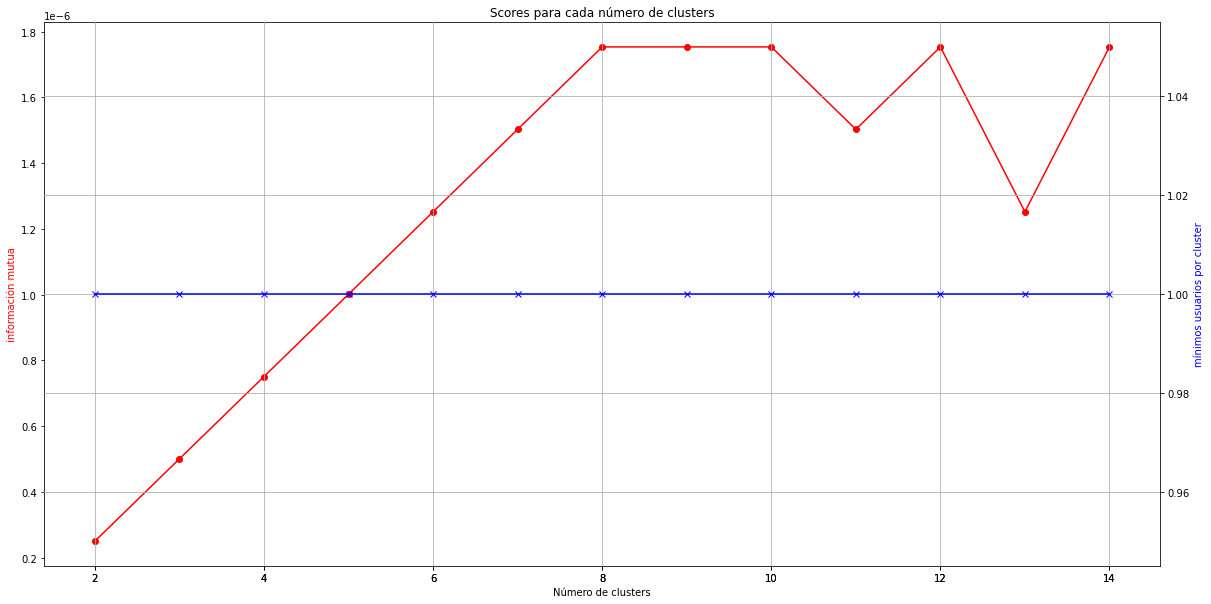

In [36]:
# create the general figure
fig1 = plt.figure(figsize=(20, 10))
 
# and the first axes using subplot populated with data 
ax1 = fig1.add_subplot(111)
ax1.yaxis.label.set_color('red') 
line1 = ax1.plot(num_clusters, list(zip(*scores))[0], 'o-', color="red", label="información mutua")
plt.ylabel("información mutua")

# now, the second axes that shares the x-axis with the ax1
ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
line2 = ax2.plot(num_clusters, list(zip(*scores))[1], 'xr-', color="blue", label="mínimos usuarios por cluster")
ax2.yaxis.tick_right()

ax2.yaxis.set_label_position("right")

plt.ylabel("mínimos usuarios por cluster")
ax2.yaxis.label.set_color('blue') 
plt.xlabel("Número de clusters")
plt.title("Scores para cada número de clusters")
plt.grid(True)
plt.show()